Let's just get a quick sparsity overview of the methods so far.

In [176]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

import matplotlib.pyplot as plt
import math

In [177]:
import os
from os import listdir

In [178]:
#BASE_PATH_DATA = '../data/'
BASE_PATH_DATA = '/scratch/ns3429/sparse-subset/data/'

In [179]:
n_epochs = 25
batch_size = 64
lr = 0.001
b1 = 0.9
b2 = 0.999
img_size = 28
channels = 1

log_interval = 20


z_size = 40

n = 28 * 28

# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [180]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")

In [181]:
print("Device")
print(device)

Device
cuda:0


In [182]:
np.random.seed(100)

In [183]:
import scipy.io as sio

In [184]:
a = sio.loadmat(BASE_PATH_DATA + 'zeisel/zeisel_data.mat')
data= a['zeisel_data'].T
N,d=data.shape
for i in range(d):
    #data[i,:]=data[i,:]/np.linalg.norm(data[i,:])
    #mi = np.mean(data[:,i])
    #std = np.std(data[:,i])
    #data[:,i] = (data[:,i] - mi) / std
    ma = np.max(data[:,i])
    mi = np.min(data[:,i])
    data[:, i] = (data[:, i] - mi) / (ma - mi)

In [185]:
input_size = d

In [186]:
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data[slices[:upto]]
test_data = data[slices[upto:]]

train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [187]:
print(train_data.std(dim = 0).mean())
print(test_data.std(dim = 0).mean())

tensor(0.2263, device='cuda:0')
tensor(0.2223, device='cuda:0')


In [188]:
def loss_function_per_autoencoder(x, mu_x, logvar_x, mu_latent, logvar_latent):
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, reduction='sum')
    loss_rec = -torch.sum(
            (-0.5 * np.log(2.0 * np.pi))
            + (-0.5 * logvar_x)
            + ((-0.5 / torch.exp(logvar_x)) * (x - mu_x) ** 2.0))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp())
    #print(loss_rec.item(), KLD.item())
    return loss_rec + 130640 * KLD

In [189]:
# KLD of D(P_1||P_2) where P_i are Gaussians, assuming diagonal
def kld_joint_autoencoders(mu_1, mu_2, logvar_1, logvar_2):
    # equation 6 of Tutorial on Variational Autoencoders by Carl Doersch
    # https://arxiv.org/pdf/1606.05908.pdf
    mu_12 = mu_1 - mu_2
    kld = 0.5 * (-1 - (logvar_1 - logvar_2) + mu_12.pow(2) / logvar_2.exp() + torch.exp(logvar_1 - logvar_2))
    #print(kld.shape)
    kld = torch.sum(kld, dim = 1)
    
    return kld.sum()

In [190]:
# for joint
def loss_function_joint(x, ae_1, ae_2):
    # assuming that both autoencoders return recon_x, mu, and logvar
    # try to make ae_1 the vanilla vae
    # ae_2 should be the L1 penalty VAE
    mu_x_1, logvar_x_1, mu_latent_1, logvar_latent_1 = ae_1(x)
    mu_x_2, logvar_x_2, mu_latent_2, logvar_latent_2 = ae_2(x)
    
    loss_vae_1 = loss_function_per_autoencoder(x, mu_x_1, logvar_x_1, mu_latent_1, logvar_latent_1)
    loss_vae_2 = loss_function_per_autoencoder(x, mu_x_2, logvar_x_2, mu_latent_2, logvar_latent_2)
    joint_kld_loss = kld_joint_autoencoders(mu_latent_1, mu_latent_2, logvar_latent_1, logvar_latent_1)
    #print("Losses")
    #print(loss_vae_1)
    #print(loss_vae_2)
    #print(joint_kld_loss)
    return loss_vae_1, loss_vae_2, joint_kld_loss

Does L1 work if we normalize after every step?

In [191]:
# L1 VAE model we are loading
class VAE_l1_diag(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size):
        super(VAE_l1_diag, self).__init__()
        
        self.diag = nn.Parameter(torch.normal(torch.zeros(input_size), 
                                 torch.ones(input_size)).to(device).requires_grad_(True))
        
        # self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)
        self.fc5 = nn.Linear(hidden_layer_size, input_size)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU()
        )
        
        self.fc3_bn = nn.BatchNorm1d(hidden_layer_size)

    def encode(self, x):
        self.selection_layer = torch.diag(self.diag)
        h0 = torch.mm(x, self.selection_layer)
        h1 = self.encoder(h0)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.leaky_relu(self.fc3_bn(self.fc3(z)))
        mu_x = F.leaky_relu(self.fc4(h))
        #mu_x = self.fc4(h)
        logvar_x = self.fc5(h)
        return mu_x, logvar_x

    def forward(self, x):
        mu_latent, logvar_latent = self.encode(x)
        z = self.reparameterize(mu_latent, logvar_latent)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu_latent, logvar_latent


In [192]:
def train_l1(df, model, optimizer, epoch):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()
        mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
        loss = loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent)
        loss += 1000000 * torch.norm(model.diag, p = 1)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        with torch.no_grad():
            model.diag.data /= torch.norm(model.diag.data, p = 2)
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data) / len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    


In [193]:
def test(df, model, epoch):
    model.eval()
    test_loss = 0
    inds = np.arange(df.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(df)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = df[batch_ind, :]
            batch_data = batch_data.to(device)
            mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
            test_loss += loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent).item()


    test_loss /= len(df)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [194]:
model_l1_diag = VAE_l1_diag(input_size, 200, 50)

model_l1_diag.to(device)
model_l1_optimizer = torch.optim.Adam(model_l1_diag.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [195]:
for epoch in range(1, n_epochs + 1):
        train_l1(train_data, model_l1_diag, model_l1_optimizer, epoch)
        test(test_data, model_l1_diag, epoch)

Train Epoch: 1 [0/2404 (0%)]	Loss: 49456560.000000
Train Epoch: 1 [1280/2404 (53%)]	Loss: 577130.812500
====> Epoch: 1 Average loss: 1965976.6955
====> Test set loss: 4905.2408


In [196]:
bins = [10**(-i) for i in range(10)]
bins.reverse()
bins += [10]
np.histogram(model_l1_diag.diag.abs().clone().detach().cpu().numpy(), bins = bins)

(array([   0,    0,    1,   26,  304, 1826, 1175,  660,    8,    0]),
 array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
        1.e-01, 1.e+00, 1.e+01]))

In [197]:
with torch.no_grad():
    train_pred = model_l1_diag(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = model_l1_diag(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [198]:
test_data[0, :]

tensor([0.5910, 0.2284, 0.3724,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [199]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(1708, device='cuda:0')
tensor(1105, device='cuda:0')


In [200]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(1.6312, device='cuda:0')
tensor(1.5704, device='cuda:0')


First try Pretrained VAE and then gumble trick with it

Then try joint training VAE and Gumbel Model

In [201]:
# Vanilla VAE model
# try with gaussian decoder
class VAE(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size):
        super(VAE, self).__init__()

        #self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)
        self.fc5 = nn.Linear(hidden_layer_size, input_size)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU()
        )
        
        self.fc3_bn = nn.BatchNorm1d(hidden_layer_size)
        
        #self.decoder = nn.Sequential()

    def encode(self, x):
        #h1 = F.relu(self.fc1(x))
        h1 = self.encoder(x)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):    
        h = F.leaky_relu(self.fc3_bn(self.fc3(z)))
        mu_x = F.leaky_relu(self.fc4(h))
        #mu_x = self.fc4(h)
        logvar_x = self.fc5(h)
        return mu_x, logvar_x

    def forward(self, x):
        mu_latent, logvar_latent = self.encode(x)
        z = self.reparameterize(mu_latent, logvar_latent)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu_latent, logvar_latent


# Pretrain VAE First

In [202]:
pretrain_vae = VAE(input_size, 200, 50)

pretrain_vae.to(device)
pretrain_vae_optimizer = torch.optim.Adam(pretrain_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [203]:
def train(df, model, optimizer, epoch):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()
        mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
        loss = loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    


In [204]:
for epoch in range(1, n_epochs + 1):
        train(train_data, pretrain_vae, pretrain_vae_optimizer, epoch)
        test(test_data, pretrain_vae, epoch)

Train Epoch: 1 [0/2404 (0%)]	Loss: 827268.125000
Train Epoch: 1 [1280/2404 (53%)]	Loss: 28012.517578
====> Epoch: 1 Average loss: 110572.5380
====> Test set loss: 11155.1012


In [205]:
with torch.no_grad():
    train_pred = pretrain_vae(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = pretrain_vae(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [206]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(1.6304, device='cuda:0')
tensor(1.5734, device='cuda:0')


In [207]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(1873, device='cuda:0')
tensor(1105, device='cuda:0')


In [208]:
for p in pretrain_vae.parameters():
    p.requires_grad = False

In [209]:
pretrain_vae.requires_grad_(False)

VAE(
  (fc21): Linear(in_features=200, out_features=50, bias=True)
  (fc22): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=4000, bias=True)
  (fc5): Linear(in_features=200, out_features=4000, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (fc3_bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_runni

## Train Gumbel with the Pre-Trained VAE

In [210]:
def train_pre_trained(df, model, optimizer, epoch, pretrained_model):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()
        mu_x, logvar_x, mu_latent, logvar_latent = model(batch_data)
        with torch.no_grad():
            _, _, mu_latent_2, logvar_latent_2 = pretrained_model(batch_data)
        
        loss = loss_function_per_autoencoder(batch_data, mu_x, logvar_x, mu_latent, logvar_latent)
        loss += 1000*F.mse_loss(mu_latent, mu_latent_2, reduction = 'sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [211]:
def gumbel_keys(w):
    # sample some gumbels
    uniform = (1.0 - EPSILON) * torch.rand_like(w) + EPSILON
    z = torch.log(-torch.log(uniform))
    w = w + z
    return w


#equations 3 and 4 and 5
def continuous_topk(w, k, t, separate=False):
    softmax = nn.Softmax(dim = -1)
    khot_list = []
    onehot_approx = torch.zeros_like(w, dtype = torch.float32)
    for i in range(k):
        ### conver the following into pytorch
        #khot_mask = tf.maximum(1.0 - onehot_approx, EPSILON)
        max_mask = 1 - onehot_approx < EPSILON
        khot_mask = 1 - onehot_approx
        khot_mask[max_mask] = EPSILON
        
        w += torch.log(khot_mask)
        #onehot_approx = tf.nn.softmax(w / t, axis=-1)
        onehot_approx = softmax(w/t)
        khot_list.append(onehot_approx)
    if separate:
        return torch.stack(khot_list)
    else:
        return torch.sum(torch.stack(khot_list), dim = 0) 


def sample_subset(w, k, t=0.1):
    '''
    Args:
        w (Tensor): Float Tensor of weights for each element. In gumbel mode
            these are interpreted as log probabilities
        k (int): number of elements in the subset sample
        t (float): temperature of the softmax
    '''
    w = gumbel_keys(w)
    return continuous_topk(w, k, t)

In [212]:
# L1 VAE model we are loading
class VAE_Gumbel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size, k, t = 0.1):
        super(VAE_Gumbel, self).__init__()
        
        self.k = k
        self.t = t
        
        self.weight_creator = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, input_size)
        )
        
        #self.fc1 = nn.Linear(input_size, hidden_layer_size)
        #self.fcextra = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)
        self.fc5 = nn.Linear(hidden_layer_size, input_size)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.BatchNorm1d(hidden_layer_size),
            nn.LeakyReLU()
        )
        
        self.fc3_bn = nn.BatchNorm1d(hidden_layer_size)

    def encode(self, x):
        w = self.weight_creator(x)
        subset_indices = sample_subset(w, self.k, self.t)
        x = x * subset_indices
        h1 = self.encoder(x)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.leaky_relu(self.fc3_bn(self.fc3(z)))
        mu_x = F.leaky_relu(self.fc4(h))
        #mu_x = self.fc4(h)
        logvar_x = self.fc5(h)
        return mu_x, logvar_x

    def forward(self, x):
        mu_latent, logvar_latent = self.encode(x)
        z = self.reparameterize(mu_latent, logvar_latent)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu_latent, logvar_latent


In [213]:
vae_gumbel_with_pre = VAE_Gumbel(input_size, 200, 50, k = 50)
vae_gumbel_with_pre.to(device)
vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [214]:
for epoch in range(1, n_epochs + 1):
        train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, epoch, pretrain_vae)
        test(test_data, vae_gumbel_with_pre, epoch)

Train Epoch: 1 [0/2404 (0%)]	Loss: 802522.687500
Train Epoch: 1 [1280/2404 (53%)]	Loss: 51021.445312
====> Epoch: 1 Average loss: 162977.3032
====> Test set loss: 6603.3549


In [215]:
with torch.no_grad():
    train_pred = vae_gumbel_with_pre(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = vae_gumbel_with_pre(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [216]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(1.6257, device='cuda:0')
tensor(1.5634, device='cuda:0')


In [217]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(1881, device='cuda:0')
tensor(1105, device='cuda:0')


# Joint Training

In [218]:
# model 1 should be vanilla

def train_joint(df, model1, model2, optimizer, epoch):
    model1.train()
    model2.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :]
        
        optimizer.zero_grad()

        
        loss_vae_1, loss_vae_2, joint_kld_loss = loss_function_joint(batch_data, model1, model2)
        loss = (loss_vae_1 + loss_vae_2 + 1000 * joint_kld_loss)
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [219]:
def test_joint(df, model1, model2, epoch):
    model1.eval()
    model2.eval()
    test_loss = 0
    inds = np.arange(df.shape[0])
    with torch.no_grad():
        for i in range(math.ceil(len(df)/batch_size)):
            batch_ind = inds[i * batch_size : (i+1) * batch_size]
            batch_data = df[batch_ind, :]
            batch_data = batch_data.to(device)
            loss_vae_1, loss_vae_2, joint_kld_loss = loss_function_joint(batch_data, model1, model2)
        
            test_loss += (loss_vae_1 + loss_vae_2 + 1000 * joint_kld_loss).item()


    test_loss /= len(df)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [220]:
joint_vanilla_vae = VAE(input_size, 200, 50)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(input_size, 200, 50, k = 50)
joint_vae_gumbel.to(device)


joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [221]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch)

Train Epoch: 1 [0/2404 (0%)]	Loss: 1764689.125000
Train Epoch: 1 [1280/2404 (53%)]	Loss: 93686.765625
====> Epoch: 1 Average loss: 289752.5646
====> Test set loss: 20543.1331


In [222]:
with torch.no_grad():
    train_pred = joint_vae_gumbel(train_data[0:64, :])[0]
    train_pred[train_pred < 0.001] = 0 

    test_pred = joint_vae_gumbel(test_data[0:64,:])[0]
    test_pred[test_pred < 0.001] = 0 

In [223]:
with torch.no_grad():
    print(torch.sum((train_pred - train_data[0:64, :]).abs()) / 64/500)
    print(torch.sum((test_pred - test_data[0:64, :]).abs()) / 64/500)

tensor(1.6355, device='cuda:0')
tensor(1.5679, device='cuda:0')


In [224]:
print(torch.sum(test_pred[0,:] != 0))
print(torch.sum(test_data[0,:] != 0))

tensor(1818, device='cuda:0')
tensor(1105, device='cuda:0')


### Let's actually Garph this.

### Try it out at Gumbel sparsity of k = 10, 25, 50, 100, 250

### Graph Test MSE Loss

## Graph the mean activations at k = 50

In [225]:
def graph_activations(test_data, model, title, file):
    preds, _, _, _ = model(test_data)
    
    pred_activations = preds.mean(dim = 0)
    
    test_activations = test_data.mean(dim = 0)
    
    x = np.arange(input_size) + 1
    
    fig = plt.figure()
    plt.plot(x, pred_activations.clone().detach().cpu().numpy(), label = 'Average Predictions')
    plt.plot(x, test_activations.clone().detach().cpu().numpy(), label = 'Average Test Data')
    
    plt.title(title)
    
    plt.legend()
    plt.savefig(file)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ns3429/sparse-subset/vae_l1.png'

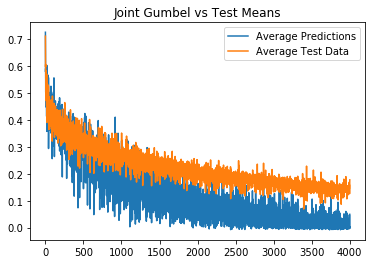

In [226]:
graph_activations(test_data, model_l1_diag, 'Joint Gumbel vs Test Means', 
                  '/scratch/ns3429/sparse-subset/vae_l1.png')

In [227]:
graph_activations(test_data, joint_vae_gumbel, 'Joint Gumbel vs Test Means', 
                  '/scratch/ns3429/sparse-subset/joint_gumbel.png')

RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 1.96 GiB total capacity; 1.15 GiB already allocated; 27.12 MiB free; 1.22 GiB reserved in total by PyTorch)

In [228]:
graph_activations(test_data, vae_gumbel_with_pre, 'Gumbel Matching Pretrained VAE vs Test Means', 
                  '/scratch/ns3429/sparse-subset/pretrained_gumbel.png')

RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 1.96 GiB total capacity; 1.19 GiB already allocated; 7.12 MiB free; 1.24 GiB reserved in total by PyTorch)

In [61]:
k_all = [5, 10, 50, 100, 500, 1000, 2000, 3000]
n_trials = 10

In [ ]:
losses_pre = []
losses_joint = []

In [ ]:
for k in k_all:
    current_k_pre_losses = []
    current_k_joint_losses = []
    for trial_i in range(n_trials):
        print("RUNNING for K {} Trial {}".format(k, trial_i), flush=True)
        vae_gumbel_with_pre = VAE_Gumbel(input_size, 200, 50, k = k)
        vae_gumbel_with_pre.to(device)
        vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                        lr=lr, 
                                                        betas = (b1,b2))
    
        joint_vanilla_vae = VAE(input_size, 200, 50)
        joint_vanilla_vae.to(device)

        joint_vae_gumbel = VAE_Gumbel(input_size, 200, 50, k = k)
        joint_vae_gumbel.to(device)


        joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + 
                                           list(joint_vae_gumbel.parameters()),
                                                lr=lr, 
                                                betas = (b1,b2))
    
        for epoch in (1, n_epochs + 1):
            train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, epoch, pretrain_vae)
            train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch)
    
        test_pred_pre = vae_gumbel_with_pre(test_data)[0]
        test_pred_pre[test_pred_pre < 0.001] = 0 
    
        test_pred_joint = joint_vanilla_vae(test_data)[0]
        test_pred_joint[test_pred_joint < 0.001] = 0
    
        with torch.no_grad():
            mae_pre = torch.sum((test_pred_pre - test_data).abs()) / len(test_data) / 500
            mae_joint = torch.sum((test_pred_joint - test_data).abs()) / len(test_data) / 500
        
        current_k_pre_losses.append(mae_pre.cpu().item())
        current_k_joint_losses.append(mae_joint.cpu().item())
        
        # for freeing memory faster
        del vae_gumbel_with_pre
        del vae_gumbel_with_pre_optimizer
        del joint_vanilla_vae
        del joint_vae_gumbel
        del joint_optimizer
        del test_pred_pre
        del test_pred_joint

        torch.cuda.empty_cache()
        
    
    losses_pre.append(np.mean(current_k_pre_losses))
    losses_joint.append(np.mean(current_k_joint_losses))
    
    
    
fig = plt.figure()
plt.plot(k_all, losses_pre, label = 'Average MAE Losses with Gumbel Matching Pretrained')
plt.plot(k_all, losses_joint, label = 'Average MAE Losses with Gumbel Joint Training')

plt.title("Effect on Sparsity on MAE Loss")
plt.xlabel('Sparsity Level (Number of Non-Zero Features)')
plt.ylabel('Per Neuron Average MAE Loss')
plt.legend()

plt.savefig('/scratch/ns3429/sparse-subset/comparing_across_sparsity.png')